**IMPLICIT MODELING USING SIGNED DISTANCE FUNCTION**

By H. Hernández (2025) for CONEIMIN XVIII

Forma de la matriz de distancias: (33, 33)


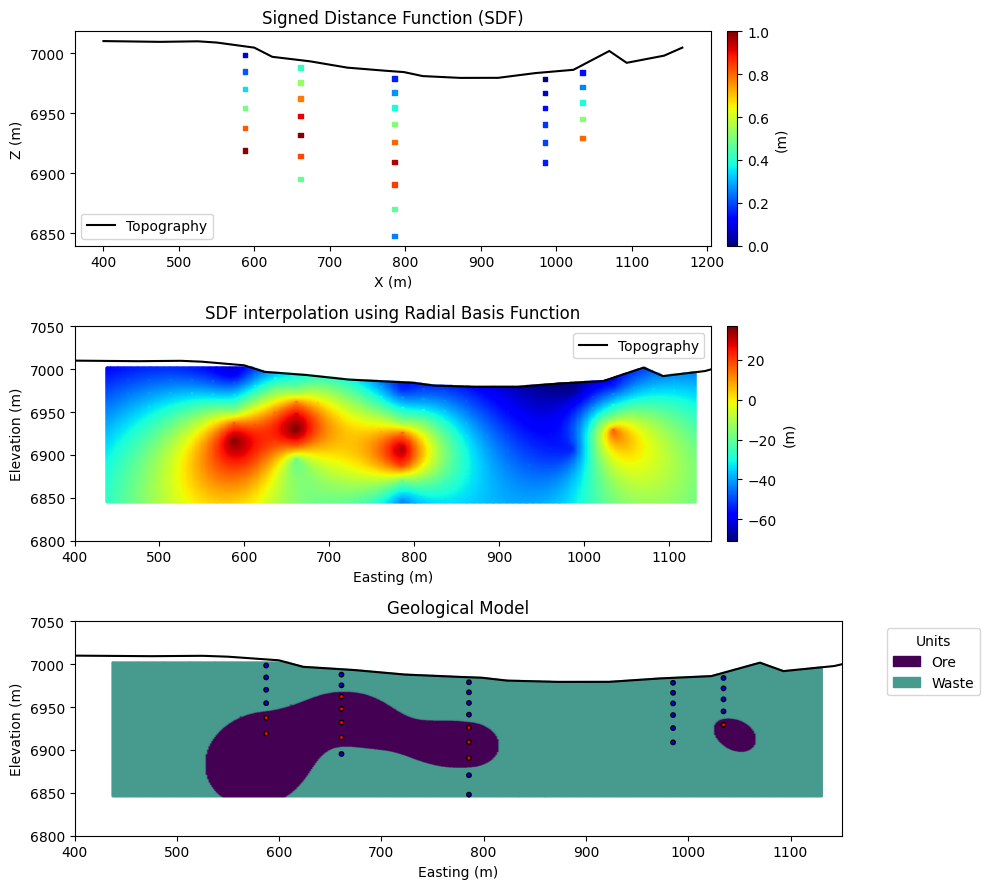

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from scipy.interpolate import Rbf
from sklearn.neighbors import KNeighborsClassifier
filein = r"C:\Users\nubem\Desktop\INVESTIGACIÓN 2025\MODELO GEOLOGICO 3D\JULIO 2025\CASO2/Resistivity_and_Topography_Data13.xlsx"  # where the data is located
df = pd.read_excel(filein)
df_copy = df.copy()
df.drop(columns=["Cond", "Resource", "X2", "Z2", "Res"], inplace=True)
# Eliminar filas con valores NaN
df = df.dropna()
df_0 = pd.read_excel(filein)
xl_file = pd.ExcelFile(filein)
df_topo = xl_file.parse('LINE_B_TOPO')

### 1. Creación de la cuadricula objetivo:
x = df_0['X2']
z = df_0['Z2']
x_min, x_max = x.min(), x.max()
z_min, z_max = z.min(), z.max()
x_grid = np.linspace(x_min, x_max, 500)  # 500 puntos en el eje X
z_grid = np.linspace(z_min, z_max, 500)  # 500 puntos en el eje Z
xx, zz = np.meshgrid(x_grid, z_grid)  # Crear la malla
points = np.column_stack((x, z))
df_grid = pd.DataFrame({
    'X': xx.ravel(),  # Aplanar la matriz xx
    'Z': zz.ravel()   # Aplanar la matriz zz
})
df_points = pd.DataFrame({
    'X': points[:, 0],  # Coordenada X de los puntos
    'Z': points[:, 1],  # Coordenada Z de los puntos
})
df_completo = pd.concat([df_grid, df_points], ignore_index=True)
df2 = df_completo.copy()
df2 = df2.drop_duplicates(subset=['X', 'Z'])
### 2. Calculo de distancias por cada dominio K:
X = df['X'].values
Z = df['Z'].values
Rocktype = df['Drillholes'].values  # Asumimos que Rocktype es binario (0 o 1)
dist_matrix = np.sqrt((X[:, np.newaxis] - X)**2 + (Z[:, np.newaxis] - Z)**2)
print("Forma de la matriz de distancias:", dist_matrix.shape)  # Debería ser (34, 34)
distances = np.zeros_like(X)
domain_indices = np.where(Rocktype == 1)[0]
other_indices = np.where(Rocktype == 0)[0]
if len(domain_indices) > 0 and len(other_indices) > 0:
    # Distancia negativa para los puntos dentro del dominio de la clase 1
    min_dist_to_other = np.min(dist_matrix[domain_indices[:, None], other_indices], axis=1)
    distances[domain_indices] = -min_dist_to_other
    min_dist_to_domain = np.min(dist_matrix[other_indices[:, None], domain_indices], axis=1)
    distances[other_indices] = min_dist_to_domain
df['distance'] = distances

### 3. Interpolación de distancias con función de base radial:
df3 = pd.DataFrame({'X': df2['X'], 'Z': df2['Z']})
try:
    x = df["X"]
    y = df["Z"]
    z = df["distance"]
    rbf = Rbf(x, y, z, function="multiquadric", epsilon=0.1)
    ZI = rbf(df2["X"].to_numpy(), df2["Z"].to_numpy())
    df3["RBF_D"] = ZI.flatten()
    df3["Rocktype_rbf"] = np.where(df3["RBF_D"] <= 0, 1, 0)  # Asignar 1 si RBF_D <= 0, 0 en otro caso
except np.linalg.LinAlgError:
    print("Error al calcular la interpolación RBF para distance. La matriz es singular. Revisa los datos.")
    df3["RBF_D"] = np.nan
    df3["Rocktype_rbf"] = np.nan

# 4. Crear el gráficos:

cmap_discreta = ListedColormap(['#440154', '#469A8E'])
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
ax1 = axs[0]
ax1.scatter(df['X'], df['Z'], c=df['distance'], cmap="jet", s=10, marker="s")
ax1.plot(df_topo['X2'], df_topo['Z2'], 'k', label='Topography')
ax1.legend()
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Z (m)')
ax1.set_title('Signed Distance Function (SDF)')
cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap="jet"), ax=ax1, orientation='vertical', pad=0.02)
cbar1.set_label('(m)')
ax2 = axs[1]
topo_z = np.interp(df3['X'], df_topo['X2'], df_topo['Z2'])
mask = df3['Z'] <= topo_z
df3_filtered = df3[mask]
sc2 = ax2.scatter(df3_filtered['X'], df3_filtered['Z'], c=df3_filtered['RBF_D'], cmap="jet", s=1, marker="s")
ax2.plot(df_topo['X2'], df_topo['Z2'], 'k', label='Topography')
ax2.set_xlim(400, 1150)
ax2.set_ylim(6800, 7050)
ax2.legend()
ax2.set_xlabel('Easting (m)')
ax2.set_ylabel('Elevation (m)')
ax2.set_title('SDF interpolation using Radial Basis Function')
cbar2 = plt.colorbar(sc2, ax=ax2, orientation='vertical', pad=0.02)
cbar2.set_label('(m)')
ax3 = axs[2]
color_0 = 'red'   # Ore
color_1 = 'blue'  # Waste
cmap_resources = ListedColormap([color_0, color_1])
topo_z = np.interp(df3['X'], df_topo['X2'], df_topo['Z2'])
mask = df3['Z'] <= topo_z
df3_filtered = df3[mask]
ax3.scatter(df3_filtered['X'], df3_filtered['Z'], c=df3_filtered['Rocktype_rbf'], cmap=cmap_discreta, s=1, marker='o', alpha=0.3)
ax3.plot(df_topo['X2'], df_topo['Z2'], 'k', label='Topography')
ax3.scatter(df['X'], df['Z'], c=df['Drillholes'], cmap=ListedColormap([color_0, color_1]), s=10, marker='o', edgecolor='black', label='Drillholes')
ax3.set_xlabel('Easting (m)')
ax3.set_ylabel('Elevation (m)')
ax3.set_title('Geological Model')
ax3.set_xlim(400, 1150)
ax3.set_ylim(6800, 7050)
patches = [plt.Rectangle((0, 0), 1, 1, color=cmap_discreta(i)) for i in range(2)]
ax3.legend(patches, ['Ore', 'Waste'], title='Units', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()